# Importing Libraries

In [1]:
import numpy as np

import scipy as sp
from scipy.signal import savgol_filter
from scipy import interpolate

import matplotlib.pyplot as plt
import os

from classy import Class

# Fiducial Cosmology: $\Lambda$CDM

- Planck 2015 (https://arxiv.org/pdf/1502.01589.pdf)
- Effective Redshift from Data: BOSS CMASS 

In [2]:
# Effective redshift of Data
z_effective = 0.56

# Parameters from fiducial cosmology
H0_fid = 67.48                        # Hubble parameter 
h_fid = H0_fid/100                    # h 
omcdm_h2_fid = 0.1194                 # Om*h^2 CDM 
Om_cdm_fid = omcdm_h2_fid/h_fid/h_fid # CDM density
omb_h2_fid = 0.02225                  # Om*h^2 baryons 
Om_b_fid = omb_h2_fid/h_fid/h_fid     # Baryon density
Omega_K_fid = 0.0                     # Curvature density
ns_fid = 0.9682                       # n_s index
tau_fid = 0.079                       # Optical depth 
Neff_fid = 3.046                      # Effective number of neutrinos
As_10up9_exp_2tau = 1.875             # As*10^9*exp(-2*tau)
As_fid = As_10up9_exp_2tau/(10**9)/np.exp(-2*tau_fid)# Primordial spectrum As
#r_s_fid = 147.41
print('A_s fiducial obtained: ',As_fid)
print('Omega Matter calculated: ',Om_cdm_fid+Om_b_fid)

A_s fiducial obtained:  2.19593661507688e-09
Omega Matter calculated:  0.31107594636484087


# Create Power Spectrum

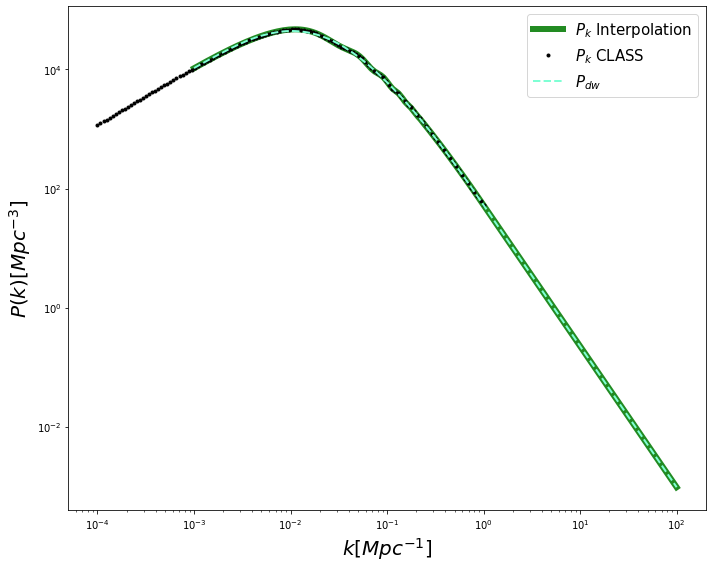

In [3]:
# Power Spectrum from CLASS using the Fiducial Cosmology
common_settings = {'output':'mPk',
                   'reio_parametrization' : 'reio_camb',
                   'A_s': As_fid,
                   'n_s': ns_fid,
                   'tau_reio': tau_fid,
                   'h' : h_fid,
                   'omega_b': omb_h2_fid,
                   'omega_cdm': omcdm_h2_fid,
                   'Omega_k': Omega_K_fid,
                   'N_eff': Neff_fid,
                   'z_max_pk':2,
                   'k_per_decade_for_pk':400,
                   'k_per_decade_for_bao':800,
                   'P_k_max_1/Mpc':1}

LCDM_cosmo_class = Class()
LCDM_cosmo_class.set(common_settings)
LCDM_cosmo_class.compute()

# k range in Mpc^-1
kmin, kmax, nk = 1e-4, 1e0, 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Pk from CLASS at effective redshift
pk_class = np.array([LCDM_cosmo_class.pk(_k, z_effective) for _k in k])
LCDM_cosmo_class.struct_cleanup()
LCDM_cosmo_class.empty()

# Power Spectrum interpolation 
fclass1 = interpolate.interp1d(np.log(k), np.log(pk_class),
                               fill_value = "extrapolate", kind='linear')

# k range in Mpc^-1 to interpolation (valid to integration)
k_interp = np.logspace(np.log10(1e-3), np.log10(1e2), 70000)
u_interp = np.log(k_interp)
mPu_interp = fclass1(u_interp)
mPk_interp = np.exp(mPu_interp)

# Power Spectrum without Wiggles (Pk_dw) using 
# Savgol filter and interpolation
pk_hat = np.exp(savgol_filter(np.log(pk_class), 61, 3))
fclass2 = interpolate.interp1d(np.log(k), np.log(pk_hat),
                               fill_value = "extrapolate", kind='linear')
mPu_hat = fclass2(u_interp)
mPk_hat = np.exp(mPu_hat)

# For k>0.6Mpc^-1 (outside wiggles zone) 
# we restore the original Pk in Pk_dw
for i in range(0,len(mPk_hat)):
    if k_interp[i]>=0.6: 
        if mPk_interp[i]/mPk_hat[i]!=1: mPk_hat[i] = mPk_interp[i]
            
plt.figure(figsize=[10,8])
plt.plot(k_interp,mPk_interp,color='forestgreen',
         linewidth=6,label=r'$P_k$ Interpolation')
plt.plot(k,pk_class,'.',color='k',markersize=6,label=r'$P_k$ CLASS')
plt.plot(k_interp,mPk_hat,'--',color='aquamarine',
         linewidth=2,label=r'$P_{dw}$')
plt.xlabel(r'$k [Mpc^{-1}]$',size=20)
plt.ylabel(r'$P(k) [Mpc^{-3}]$',size=20)
plt.xscale('log')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.tight_layout()

# Save the Power Spectrum

- Not normalizated 
- Choose a name to the file

In [4]:
my_file = 'Matter_Power_Spectrum_z_056_Planck2015.txt'

if not os.path.exists(my_file):
    np.savetxt(my_file,np.array([k_interp,mPk_interp,mPk_hat]))
else:
    num = 1
    while os.path.exists(my_file):
        my_file = 'Matter_Power_Spectrum_z_056_Planck2015_'+str(num)+'.txt'
        num += 1
    np.savetxt(my_file,np.array([k_interp,mPk_interp,mPk_hat]))